In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler
import json

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *


with open('match_verbatim_captions.json') as f:
    all_mem_captions = json.load(f)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# load model
torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


In [13]:
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512

In [14]:
# prompt = "A painting of the Great Wave off Kanagawa by Katsushika Hokusai"
prompt = all_mem_captions[0]
print(prompt)
seed = 0

The No Limits Business Woman Podcast


## Original Generation


100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


prompt: The No Limits Business Woman Podcast


,,,

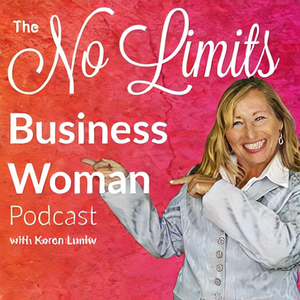
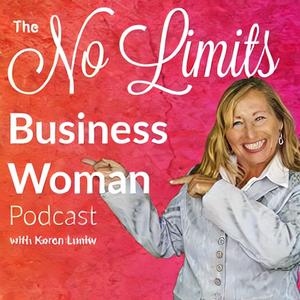
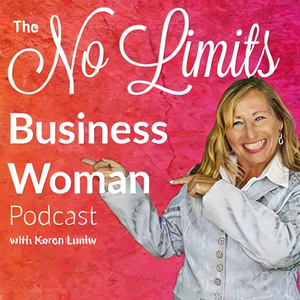
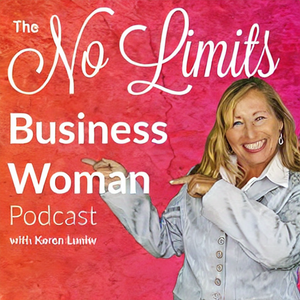

: 

In [15]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## Getting Significance Score


  0%|          | 0/50 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [00:09<00:00,  5.37it/s]

prompt:Living in the Light with Ann Graham Lotz


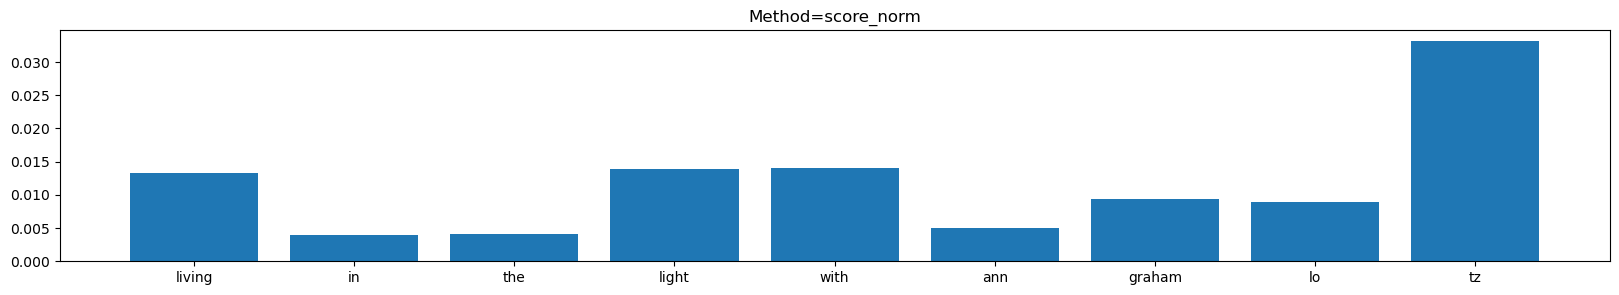

In [26]:
# get token-wise grad norm
%matplotlib inline
set_random_seed(seed)
method = "score_norm"
token_grads = pipe.get_text_cond_grad(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
    target_steps=list(range(50)),
    method=method,
)
torch.cuda.empty_cache()

prompt_tokens = pipe.tokenizer.encode(prompt)
prompt_tokens = prompt_tokens[1:-1]
prompt_tokens = prompt_tokens[:75]
token_grads = token_grads[1:(1+len(prompt_tokens))]
token_grads = token_grads.cpu().tolist()

all_tokes = []

for curr_token in prompt_tokens:
    all_tokes.append(pipe.tokenizer.decode(curr_token))

print(f"prompt:{prompt}")
plt.figure(figsize=(20, 3))
plt.bar(all_tokes, token_grads)
plt.title(f"Method={method}")
plt.show()

## Modify the Prompt According to the Significance Scorre


In [27]:
prompt_modified = "Living in the light with Ann Graham Lotz"

100%|██████████| 50/50 [00:04<00:00, 12.29it/s]


prompt modified: Living in the light with Ann Graham Lotz


,,,

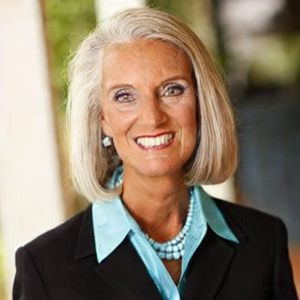
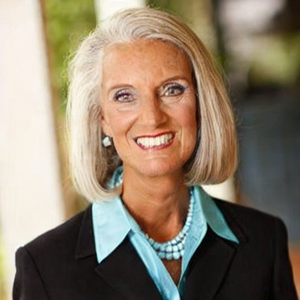
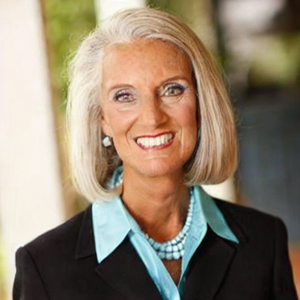
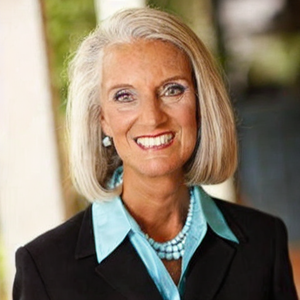

In [28]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt_modified,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt modified: {prompt_modified}")
media.show_images(outputs, width=300)